In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import dill as pickle

# Data Preprocessing

In [2]:
# fetch the data
nio = yf.Ticker("NIO")
nio

yfinance.Ticker object <NIO>

In [3]:
#Get historical data
nio_data = nio.history(start ="2015-01-01", end=date.today(), interval="1d")

nio_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-18,47.680000,48.369999,46.590000,46.910000,90697900,0,0
2021-06-21,46.549999,46.990002,45.070000,46.509998,44475700,0,0
2021-06-22,45.860001,46.549999,43.810001,44.099998,61387300,0,0
2021-06-23,44.970001,45.980000,44.610001,45.410000,39493500,0,0
2021-06-24,45.910000,46.590000,45.240002,45.459999,37595000,0,0


### Data Visualization

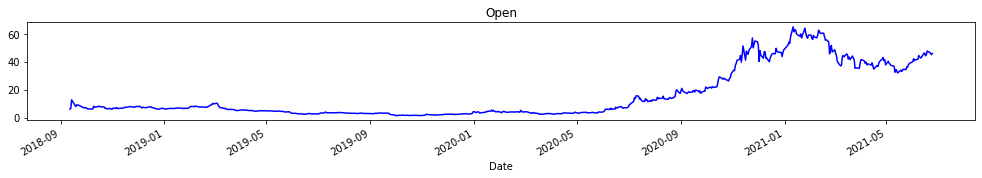

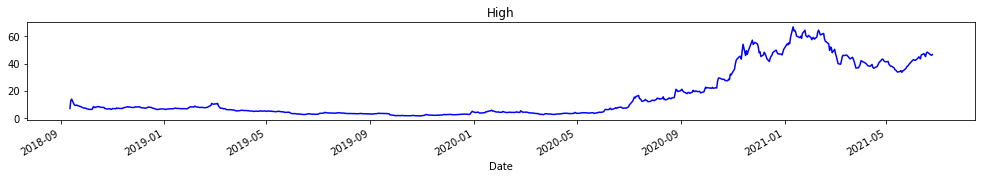

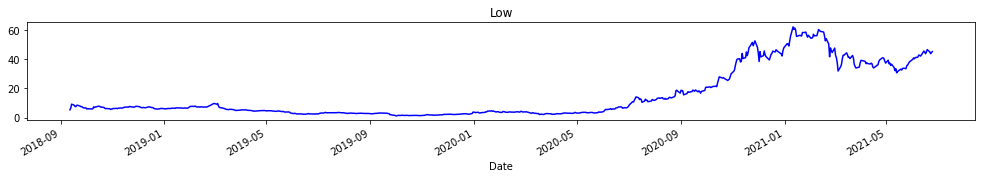

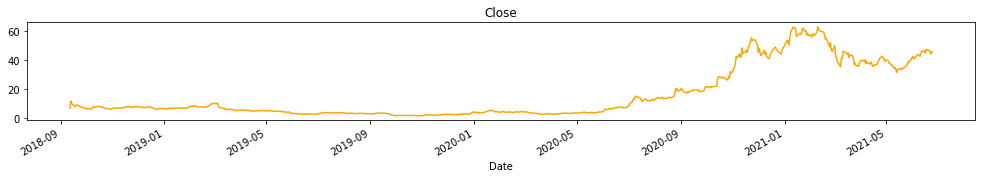

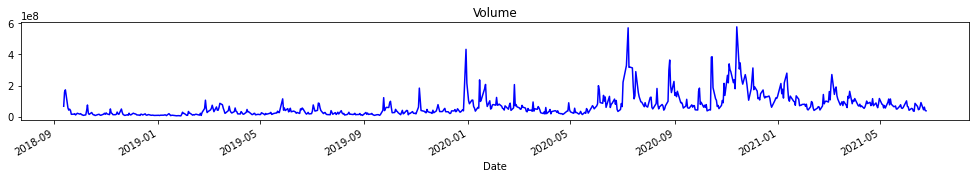

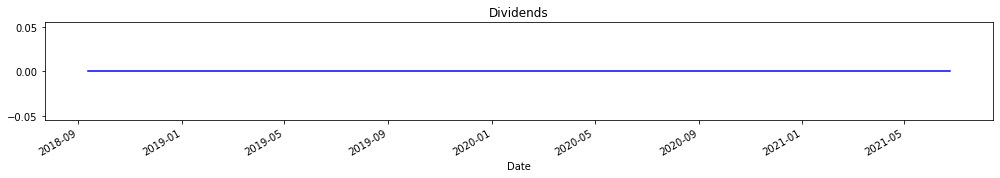

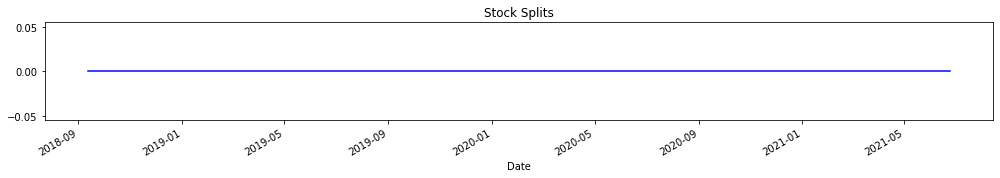

In [4]:
%matplotlib inline

for col in nio_data.columns:
    color="orange" if col == "Close" else "blue"
    nio_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
nio_data = nio_data.reset_index()
nio_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-09-12,6.00,6.93,5.35,6.60,66849000,0,0
1,2018-09-13,6.62,12.69,6.52,11.60,158346500,0,0
2,2018-09-14,12.66,13.80,9.22,9.90,172473600,0,0
3,2018-09-17,9.61,9.75,8.50,8.50,56323900,0,0
4,2018-09-18,8.73,9.10,7.67,7.68,41827600,0,0


In [6]:
#check if date is in datetime format
nio_data.Date.dtype

dtype('<M8[ns]')

In [7]:
#save the dataframe as csv
nio_data.to_csv("nio.csv")

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [8]:
#Extracting the date and close price columns
nio_df = nio_data[["Date", "Close"]]
nio_df.head()

,Date,Close
0,2018-09-12,6.60
1,2018-09-13,11.60
2,2018-09-14,9.90
3,2018-09-17,8.50
4,2018-09-18,7.68


In [9]:
#rename the columns
nio_df = nio_df.rename(columns={'Date': 'ds', 'Close': 'y'})
nio_df.head()

,ds,y
0,2018-09-12,6.60
1,2018-09-13,11.60
2,2018-09-14,9.90
3,2018-09-17,8.50
4,2018-09-18,7.68


### Splitting the Data

In [10]:
index = int(0.8 * nio_df.shape[0])
train_df = nio_df[:index]
test_df = nio_df[index:]

In [11]:
print(train_df.shape)
print(test_df.shape)

(560, 2)
(141, 2)


### Hyperparameter Tuning

In [12]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [13]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [14]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [15]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
591,2023-07-31,337.291738,-197.300059,915.335809
592,2023-08-31,342.118096,-221.356654,944.604344
593,2023-09-30,342.803840,-252.417938,970.106668
594,2023-10-31,358.414415,-268.013878,1016.888901
595,2023-11-30,376.278456,-274.546266,1067.111457


## Plotting the Forecast

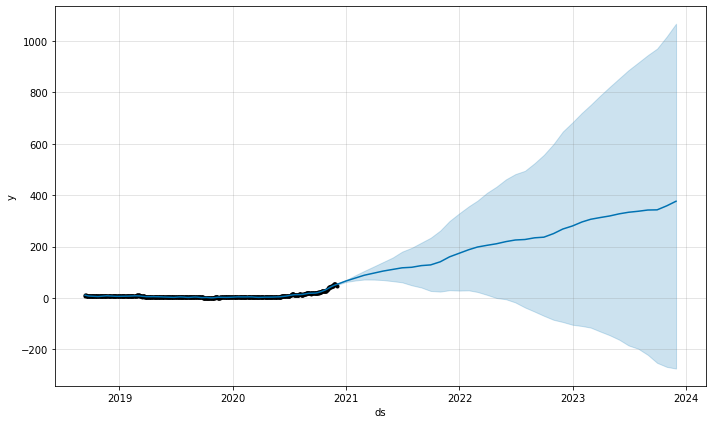

In [16]:
ax = model.plot(forecast);

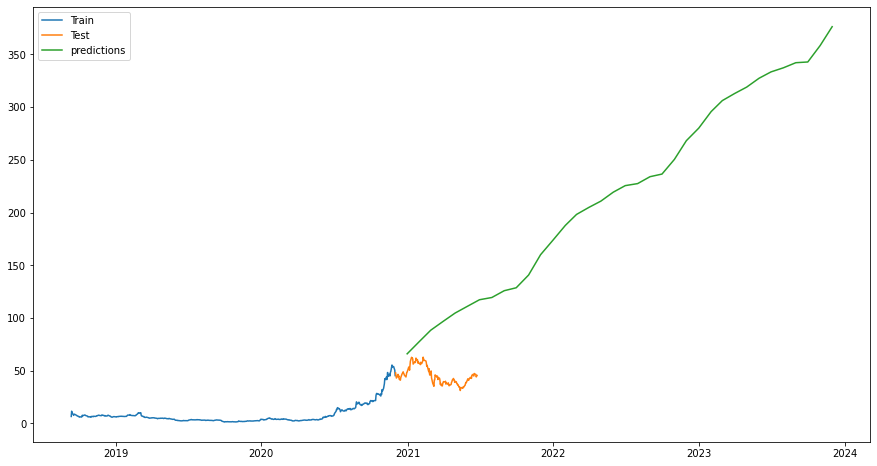

In [17]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

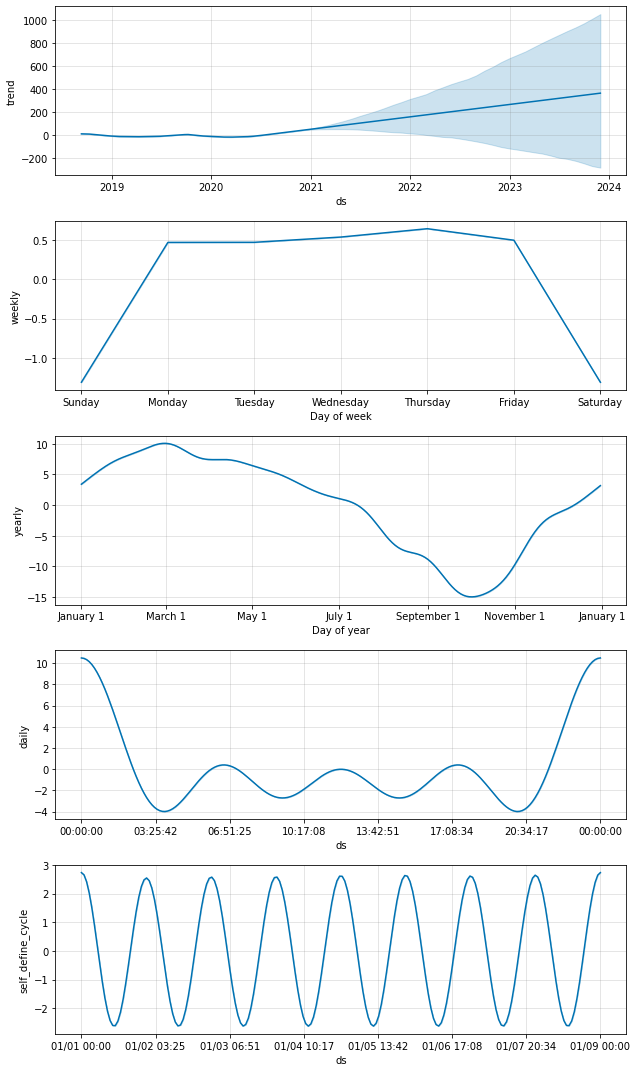

In [18]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [19]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365} days', horizon='100 days', period='180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-08-23 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
135,2020-11-24,21.583030,18.544381,24.818280,53.509998,2020-08-23
136,2020-11-25,21.753716,18.738851,24.809043,53.689999,2020-08-23
137,2020-11-27,21.905099,18.847185,24.867652,54.000000,2020-08-23
138,2020-11-30,22.343467,19.187585,25.823964,50.529999,2020-08-23
139,2020-12-01,22.486402,19.130097,25.537784,45.360001,2020-08-23


In [21]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,6.462330,2.542111,2.032220,0.195972,0.218690,0.357143
1,10 days,7.478677,2.734717,2.323487,0.220630,0.224291,0.214286
2,11 days,7.587706,2.754579,2.360770,0.215664,0.218690,0.214286
3,12 days,7.492105,2.737171,2.344917,0.208094,0.218690,0.214286
4,13 days,6.610648,2.571118,2.189316,0.208455,0.218690,0.250000


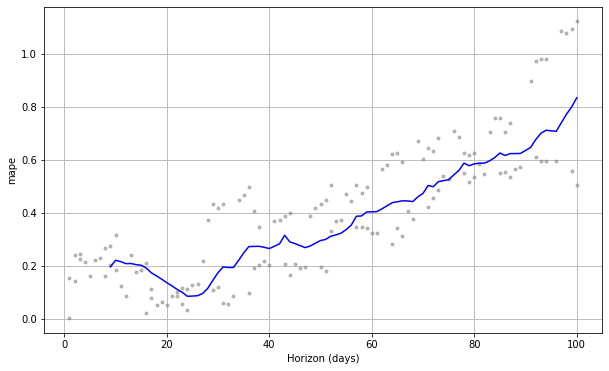

In [22]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [38]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [39]:
m.fit(nio_df)

In [40]:
pickle.dump(m,open("nio.pkl","wb"))

In [26]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as nio:
    json.dump(model_to_json(m), nio)

In [27]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
591,2023-07-31,340.576560,-196.825852,900.648817
592,2023-08-31,342.356030,-220.477481,941.400031
593,2023-09-30,344.080381,-240.010607,970.182887
594,2023-10-31,356.716968,-251.603611,1020.566575
595,2023-11-30,380.514410,-249.585558,1061.279759


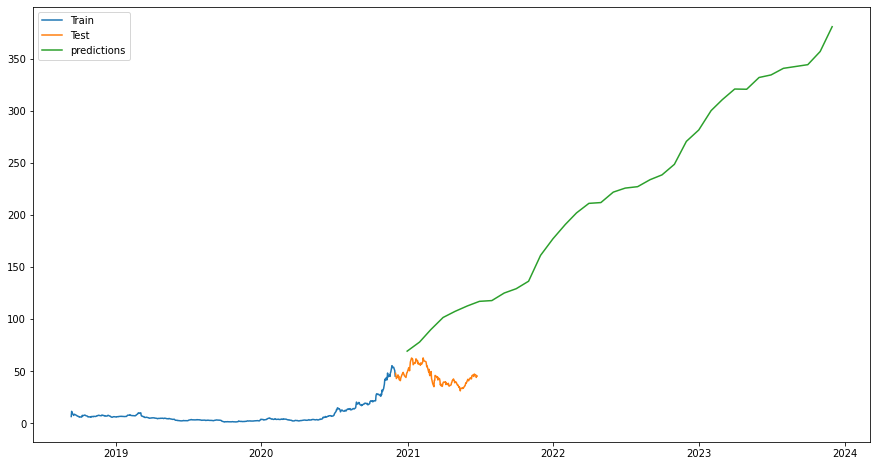

In [28]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [29]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365} days', horizon='100 days', period='180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-08-23 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,13.940344,3.733677,2.931021,0.244868,0.253798,0.000000
1,10 days,15.874646,3.984300,3.173657,0.246466,0.266902,0.071429
2,11 days,16.357027,4.044382,3.265294,0.241904,0.253798,0.071429
3,12 days,16.338453,4.042085,3.285617,0.233989,0.253798,0.071429
4,13 days,14.891118,3.858901,3.109946,0.243512,0.253798,0.071429


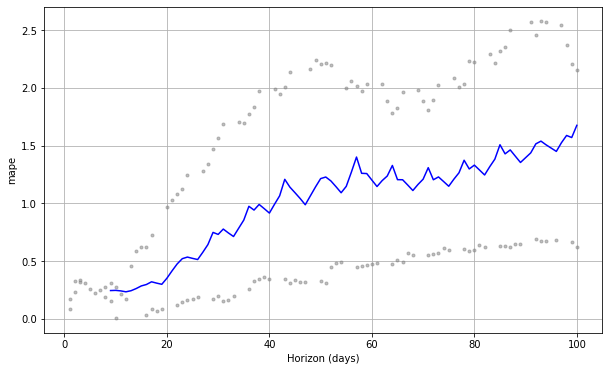

In [31]:
plot_cross_validation_metric(cv_results, metric='mape');

In [41]:
model = pickle.load(open("nio.pkl","rb"))

In [43]:
period=365
def prediction(model, period):
    future = model.make_future_dataframe(periods =period, freq="D")
    forecast = model.predict(future)
    future_ = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    print(future_)
    ax = model.plot(forecast);
    df = model.plot_components(forecast);
    return(ax, df)

In [ ]:
predict = prediction(model, period)
predict